In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# default: Load the model on the available device(s)
model = Qwen3VLForConditionalGeneration.from_pretrained(
    "weathon/smolvlm2_anti_aesthetics_7b", dtype="auto", device_map="cuda"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark")

In [4]:
import pandas as pd

df = pd.read_csv("rules.csv")
sign = lambda x: (x > 0) - (x < 0)
import pandas as pd
import re

df.columns = df.columns.str.strip()
df['Dimension'] = df['Dimension'].ffill()

df['dim_key'] = df['Dimension'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if re.search(r'\((.*?)\)', x) else x)

guide = {
    dim_key: {
        f"{row['Option']}: {sign(int(row['Score']))+1}": ": " +str(row['Description']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}

score = {
    dim_key: {
        int(row['Score']): str(row['Option']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
        num_rows: 3300
    })
})

In [6]:
dataset = dataset["train"]

In [77]:
import json
idx = 123
def rate_image(sample):
    for dim in guide.keys():
        if dim in ["unsafe type", "hands", "face", "body", "safety", "lighting aesthetic", "symmetry"]:
            continue
        messages = [
                    { 
                        "role": "user",
                        "content": [
                            {
                                "type":"text",
                                "text":f"Please rate this image for its {dim} quality. Use this guideline {guide[dim]}. Response a single number.",
                            },
                            {
                                "type": "image", 
                                "image": dataset[idx]["image_distorted"].resize((512, 512))
                            }
                        ],
                    }]

        inputs = processor.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            return_dict=True,
            return_tensors="pt"
        ) 

        inputs = inputs.to(model.device)


        id_of_interest = processor.tokenizer.convert_tokens_to_ids(["0", "1", "2"])
        id_of_interest
        import torch
        with torch.no_grad():
            logits = model(**inputs, max_new_tokens=128).logits
        prob = torch.softmax(logits[:, -1], dim=-1)
        prob_of_interest = prob[:, id_of_interest][0]
        score = torch.dot(prob_of_interest, torch.tensor([0, 1, 2], device=prob_of_interest.device).bfloat16())
        print(dim, score.item())


background 0.96875
clarity 1.3984375
color aesthetic 1.0078125
color brightness 0.044189453125
detail realism 1.03125
detail refinement 0.9375
emotion 0.87109375
lighting distinction 1.5078125
main object 1.9609375
object pairing 1.078125
richness 0.671875


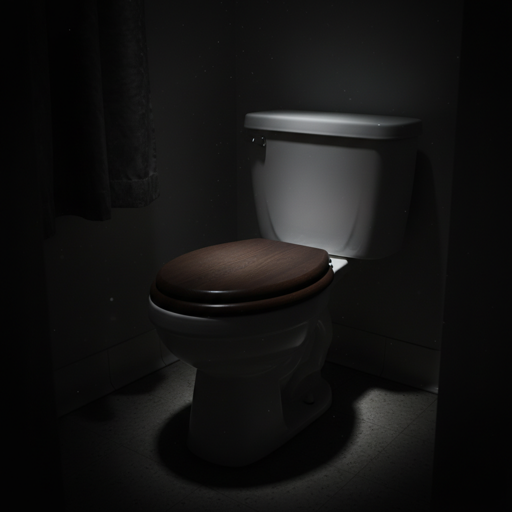

In [92]:
idx = 264
rate_image(dataset[idx]) 

dataset[idx]["image_distorted"].resize((512, 512))

In [76]:
logits = logits[:, -1, id_of_interest]

tensor([[26.0000, 27.5000, 26.0000]], device='cuda:0', dtype=torch.bfloat16)

In [77]:
torch.softmax(logits, dim=-1)

tensor([[0.1543, 0.6914, 0.1543]], device='cuda:0', dtype=torch.bfloat16)

In [9]:
# from transformers import Qwen3VLForConditionalGeneration, AutoProcessor

# # default: Load the model on the available device(s)
# model = Qwen3VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen3-VL-4B-Instruct", dtype="auto", device_map="cuda:1" 
# )

# # We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# # model = Qwen3VLForConditionalGeneration.from_pretrained(
# #     "Qwen/Qwen3-VL-4B-Instruct",
# #     dtype=torch.bfloat16,
# #     attn_implementation="flash_attention_2",
# #     device_map="auto",
# # )

# processor = AutoProcessor.from_pretrained("Qwen/Qwen3-VL-4B-Instruct")

In [10]:
# from datasets import load_dataset
# dataset = load_dataset("weathon/aas_benchmark")

In [11]:
# dataset = dataset["train"]

In [12]:
# import json
# dim = json.loads(dataset[0]["selected_dims"])[0]
# messages = [
#             { 
#                 "role": "user",
#                 "content": [
#                     {
#                         "type":"text",
#                         "text":f"Please rate this image for its {dim} quality. Use this guideline {guide[dim]}. Response a single number. **Rate on the lower end.**",
#                     },
#                     {
#                         "type": "image", 
#                         "image": dataset[0]["image_distorted"]
                            
#                     }
#                 ],
#             }]

# # Preparation for inference
# inputs = processor.apply_chat_template(
#     messages,
#     tokenize=True,
#     add_generation_prompt=True,
#     return_dict=True,
#     return_tensors="pt"
# )
# inputs = inputs.to(model.device)

# # Inference: Generation of the output
# generated_ids = model.generate(**inputs, max_new_tokens=128)
# generated_ids_trimmed = [
#     out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
# ]
# output_text = processor.batch_decode(
#     generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
# )
# print(output_text) 


In [93]:
import json
with open("eval.json", "r") as f:
    eval_results = json.load(f)

pred = eval_results["pred"]
gt = eval_results["gt"]

In [96]:
import numpy as np

pred_score = [sum(p[k] for k in p.keys() if k.endswith("_score")) for p in pred] 
gt_score = [sum([np.sign(g[k])+1 for k in g.keys() if k not in ["unsafe type", "hands", "face", "body", "safety", "lighting aesthetic", "symmetry"]]) for g in gt]

In [95]:
len(pred_score)

743

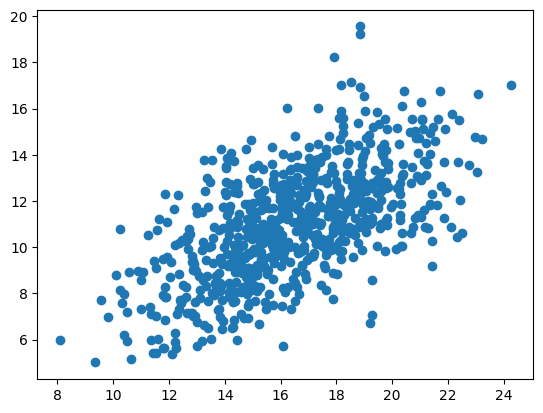

In [97]:
import pylab
noise = np.random.randn(len(pred_score)) * 0.5
pylab.scatter(pred_score, noise + gt_score, alpha=1.0)

In [98]:
from scipy.stats import pearsonr, spearmanr
pearsonr(pred_score, gt_score), spearmanr(pred_score, gt_score)

(PearsonRResult(statistic=np.float64(0.624373979208066), pvalue=np.float64(1.502024405798766e-81)),
 SignificanceResult(statistic=np.float64(0.6182213928512037), pvalue=np.float64(1.5295037414479307e-79)))

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_scores = []
gt_scores = []
pred_single = []

for i in range(len(pred)):
    for key in pred[i].keys():
        if key.endswith("_score"):
            pred_score = pred[i][key]
            gt_score = gt[i][key.replace("_score", "")]
            pred_scores.append(pred_score)
            gt_scores.append(np.sign(gt_score) + 1)
            pred_single.append(pred[i][key.replace("_score", "_pred")])

print(mean_absolute_error(gt_scores, pred_scores))



0.3073881964200777


In [101]:
import numpy as np
from sklearn.metrics import mean_absolute_error
from collections import Counter

pred_scores = []
gt_scores = []

for i in range(len(pred)):
    for key in pred[i].keys():
        if key.endswith("_score"):
            pred_score = pred[i][key]
            gt_val = gt[i][key.replace("_score", "")]
            quantized_gt = np.sign(gt_val) + 1

            pred_scores.append(pred_score)
            gt_scores.append(quantized_gt)

class_counts = Counter(gt_scores)
total_samples = len(gt_scores)

class_weights = {}
for cls in [0, 1, 2]:
    count = class_counts.get(cls, 0)
    if count > 0:
        class_weights[cls] = total_samples / count
    else:
        class_weights[cls] = 0

sample_weights = np.array([class_weights[gt] for gt in gt_scores])

wmae = mean_absolute_error(gt_scores, pred_scores, sample_weight=sample_weights)

print(wmae)

0.3678297052748552


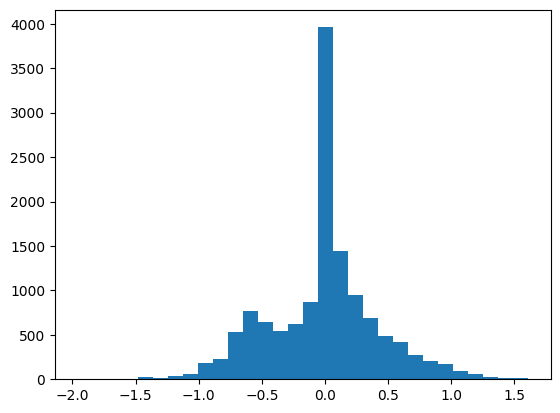

In [79]:
import numpy as np
pred_scores = np.array(pred_scores)
gt_scores = np.array(gt_scores)
pylab.hist(pred_scores - gt_scores, bins=30)
pylab.show()

In [103]:
from sklearn.metrics import f1_score, accuracy_score
print(f1_score(gt_scores, np.round(pred_scores), average='weighted'), accuracy_score(gt_scores, np.round(pred_scores)))

0.7319055957853982 0.7402422611036339


In [81]:
pred_scores[10], gt_scores[10]

(np.float64(1.21875), np.int64(1))

In [110]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark")

In [114]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
        num_rows: 3300
    })
})

In [117]:
dataset["train"] = dataset["train"].remove_columns(["hpsv2"])

In [ ]:
# def rate_image(sample):
    

DatasetDict({
    train: Dataset({
        features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
        num_rows: 3300
    })
})

In [ ]:
datase xuanzahunt

Dataset({
    features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
    num_rows: 3300
})